# Example of Forecasting a Time Series using a Tree-Based Model

 - Scikit-Learn LightGBM: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor
 - pmdarima: http://alkaline-ml.com/pmdarima/
 - AutoReg: https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg
 - STL: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL
 - savgol_filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
 - plotnine: https://plotnine.readthedocs.io/en/stable/index.html
 

In [18]:
import sys, re, time, math
import numpy as np
import pandas as pd
import pmdarima as pm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import STL
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
import plotnine
from plotnine import ggplot, aes, geom_line, geom_smooth, facet_wrap, labs, theme_bw

# Simulated Data Set

Generate a synthetic data set that has daily time steps.

Start with the dates using Pandas date_range() method: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

In [29]:
df = pd.DataFrame()
df["dt"] = pd.date_range("2015-01-01", "2021-12-31", freq = "D")
df.head()

,dt
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05


## Cyclic Calendar Features

Cyclic Calendar features = day of week and day of year. 

Use Pandas dt: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html

Also create a date (row) index.

**NOTE:** for real-world data, we would likely create many more features, like day of month, week of year, month of year, etc.

In [30]:
df["dw"] = df["dt"].dt.dayofweek+1
df["dm"] = df["dt"].dt.day
df["dy"] = df["dt"].dt.dayofyear
df["dn"] = df.index+1
df["yr"] = df["dt"].dt.year
df.head()

,dt,dw,dm,dy,dn,yr
0,2015-01-01,4,1,1,1,2015
1,2015-01-02,5,2,2,2,2015
2,2015-01-03,6,3,3,3,2015
3,2015-01-04,7,4,4,4,2015
4,2015-01-05,1,5,5,5,2015


## Convert Cyclic Calendar Features to Trigonometric Features

Trig features = sine of the cyclic calendar features (i.e. day of week, day of month, day of year).

**NOTE:** These are used to construct the target variable, but could be used in real-data sets as features / exogenous regressors.

In [31]:
df["sdw"] = np.sin(2.0 * np.pi * (df["dw"] - 1) / 7)
df["cdw"] = np.cos(2.0 * np.pi * (df["dw"] - 1) / 7)
df["sdm"] = np.sin(2.0 * np.pi * (df["dm"] - 1) / df["dt"].dt.days_in_month)
df["cdm"] = np.cos(2.0 * np.pi * (df["dm"] - 1) / df["dt"].dt.days_in_month)
df["sdy"] = np.sin(2.0 * np.pi * (df["dy"] - 1) / 366)
df["cdy"] = np.cos(2.0 * np.pi * (df["dy"] - 1) / 366)
df.head()

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643


## Holidays

Get US Federal Holidays. 

Create dummay vars for holiday, day before holiday and day after holiday.

In [32]:
cal = calendar()
holidays = cal.holidays(start = df["dt"].min(), end = df["dt"].max())
df["hd"] = df["dt"].isin(holidays).astype(int)           # Federal Holiday
df["bh"] = df["hd"].shift(periods = -1, fill_value = 0)  # Day Before Holiday
df["ah"] = df["hd"].shift(periods = +1, fill_value = 0)  # Day After Holiday
df.head(10)

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0
5,2015-01-06,2,6,6,6,2015,0.781831,0.623490,0.848644,0.528964,0.085731,0.996318,0,0,0
6,2015-01-07,3,7,7,7,2015,0.974928,-0.222521,0.937752,0.347305,0.102821,0.994700,0,0,0
7,2015-01-08,4,8,8,8,2015,0.433884,-0.900969,0.988468,0.151428,0.119881,0.992788,0,0,0
8,2015-01-09,5,9,9,9,2015,-0.433884,-0.900969,0.998717,-0.050649,0.136906,0.990584,0,0,0
9,2015-01-10,6,10,10,10,2015,-0.974928,-0.222521,0.968077,-0.250653,0.153891,0.988088,0,0,0


## Noise and Trend

Noise = random normal (0, 1) variable for each date.

Trend = step changes (randomly up or down) smoothed by savgol filter.

In [36]:
# Noise for each date
df["noise"] = np.random.normal(0, 1.0, len(df))
# Step changes randomly dispersed throughout the time series
chngpts = sorted(np.random.choice(df["dn"], size=50, replace=False))
df["change"] = np.where(df["dn"].isin(chngpts), 1, 0)
df["step"] = np.random.choice([-1,1], size=len(df), p=[0.5,0.5]) * df["change"]
df["step"] = df["step"].cumsum()
# Smooth step changes (i.e. non-linear trend)
df["trend"] = savgol_filter(df["step"].values, window_length=100, polyorder=1)
df.head()

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah,noise,change,step,trend,y
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0,-1.626860,0,0,-0.217624,105.125458
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1,0.613607,0,0,-0.210399,97.811171
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0,-1.501417,0,0,-0.203174,102.877525
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0,-0.344402,0,0,-0.195950,101.436262
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0,2.279467,0,0,-0.188725,104.551077


## Target Variable

Construct the target variable from various components.

In [37]:
df["y"] = 100 
df["y"] = df["y"] + df["trend"] + df["noise"]
df["y"] = df["y"] + (df["sdw"] + df["cdw"])
df["y"] = df["y"] + (df["sdm"] + df["cdm"])
df["y"] = df["y"] + (df["sdy"] + df["cdy"])
df["y"] = df["y"] + (2 * df["hd"])
df["y"] = df["y"] + (-2 * df["bh"])
df["y"] = df["y"] + (-2 * df["ah"])
df.head()

,dt,dw,dm,dy,dn,yr,sdw,cdw,sdm,cdm,sdy,cdy,hd,bh,ah,noise,change,step,trend,y
0,2015-01-01,4,1,1,1,2015,0.433884,-0.900969,0.000000,1.000000,0.000000,1.000000,1,0,0,-1.626860,0,0,-0.217624,101.688431
1,2015-01-02,5,2,2,2,2015,-0.433884,-0.900969,0.201299,0.979530,0.017166,0.999853,0,0,1,0.613607,0,0,-0.210399,99.266203
2,2015-01-03,6,3,3,3,2015,-0.974928,-0.222521,0.394356,0.918958,0.034328,0.999411,0,0,0,-1.501417,0,0,-0.203174,99.445012
3,2015-01-04,7,4,4,4,2015,-0.781831,0.623490,0.571268,0.820763,0.051479,0.998674,0,0,0,-0.344402,0,0,-0.195950,101.743491
4,2015-01-05,1,5,5,5,2015,0.000000,1.000000,0.724793,0.688967,0.068615,0.997643,0,0,0,2.279467,0,0,-0.188725,105.570760


# Plot

Plot the target variable.

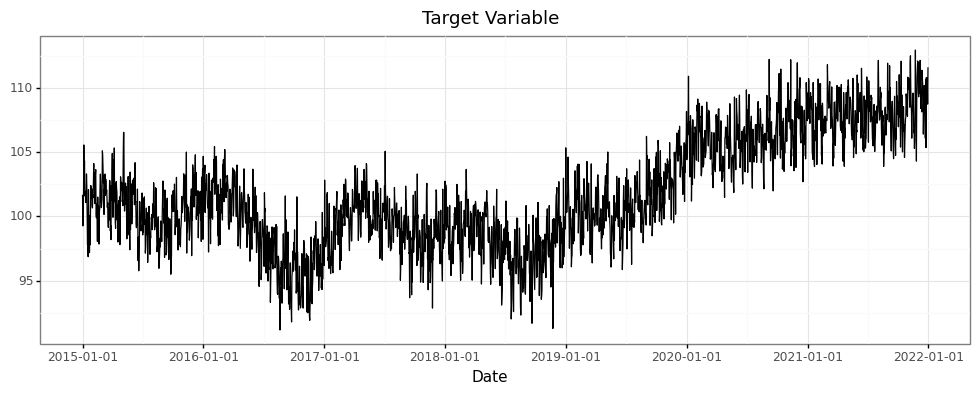

<ggplot: (121111565719)>

In [38]:
plotnine.options.figure_size = (12,4)
(
    ggplot(df, aes("dt")) +
    geom_line(aes(y="y"), color="black") +
    labs(x="Date", y="", title="Target Variable") +
    theme_bw()
)

## Features

**NOTE:** we aren't using the trig features since those were used to create the target variable. In a real-world example, we could use these along with other calendar features.

In [39]:
x_vars = ["hd","bh","ah","dw","dm","dy","dn","yr"]
print("Features =", x_vars)

Features = ['hd', 'bh', 'ah', 'dw', 'dm', 'dy', 'dn', 'yr']


## Time Series Split

Create time series splits. These are used to evaluate forecast accuracy.

- n_splits: the number of time series splits (similar to k in k-fold cross-validation)
- test_size: the number of observations in the test split (i.e. forecast horizon)
- max_train_size: the maximum number of observations in the train split
- gap: how much gap (measured in number of time steps) between splits

In [40]:
n_splits = 4
test_size = 365
ts_split = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=0)
all_splits = list(ts_split.split(df))
ts_split

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=365)

## Function to convert seconds to hours minutes seconds

Used for timing of various operations.

In [41]:
def sec_to_hms(secs):
    m, s = divmod(secs, 60)
    h, m = divmod(m, 60)
    h_str = "%d"   % int(h)
    m_str = "%02d" % int(m)
    s_str = "%02.2f" % round(s,2)
    s_str = re.sub(r'\.00$','',s_str)
    return ':'.join([h_str,m_str,s_str])

## Trend: Fit and Forecast

Fit a trend to the training split, then forecast (predict) the trend for the test split.

In [42]:
n_trend = 725
n_lags = 61
df_trend_results = pd.DataFrame()
# Loop Thru The Splits
for split in np.arange(0, n_splits):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    endog_train = df.loc[train_index,["dt","y"]].set_index("dt").squeeze().asfreq("D") # Training Split (Past) to Extract STL Decomp
    stl = STL(endog=endog_train, period=7, trend=n_trend).fit() # STL Decomp
    df_trend_act = pd.DataFrame({"trend": endog_train}) # Actuals for Training Split
    df_trend_act["split"] = split
    df_trend_act["type"] = "actual"
    df_trend_act = df_trend_act.reset_index().rename(columns={"index":"dt"})
    df_trend_fit = pd.DataFrame(stl.trend) # Fitted Trend for Training Split
    df_trend_fit["split"] = split
    df_trend_fit["type"] = "fitted"
    df_trend_fit = df_trend_fit.reset_index()
    trend_mod = AutoReg(endog=stl.trend, lags=n_lags, seasonal=False).fit() # Model the Trend
    trend_fore = trend_mod.forecast(steps=test_index.shape[0]) # Testing Split (Future) for Trend Forecast
    df_trend_fore = pd.DataFrame({"trend": trend_fore})
    df_trend_fore["split"] = split
    df_trend_fore["type"] = "forecast"
    df_trend_fore = df_trend_fore.reset_index().rename(columns={"index":"dt"}).set_index(test_index)
    df_trend_results = pd.concat([df_trend_results, df_trend_act, df_trend_fit, df_trend_fore]) # Combine Trend Fit and Forecast for each Split
    seconds = time.time() - t1
    print("De-trending time for split " + split.astype("str") + ": " + sec_to_hms(seconds))

De-trending time for split 0: 0:00:0.49
De-trending time for split 1: 0:00:0.60
De-trending time for split 2: 0:00:0.72
De-trending time for split 3: 0:00:0.87


## Plot the Trend

Plot the trend, both fit to past and forecast in future, for each time series split.

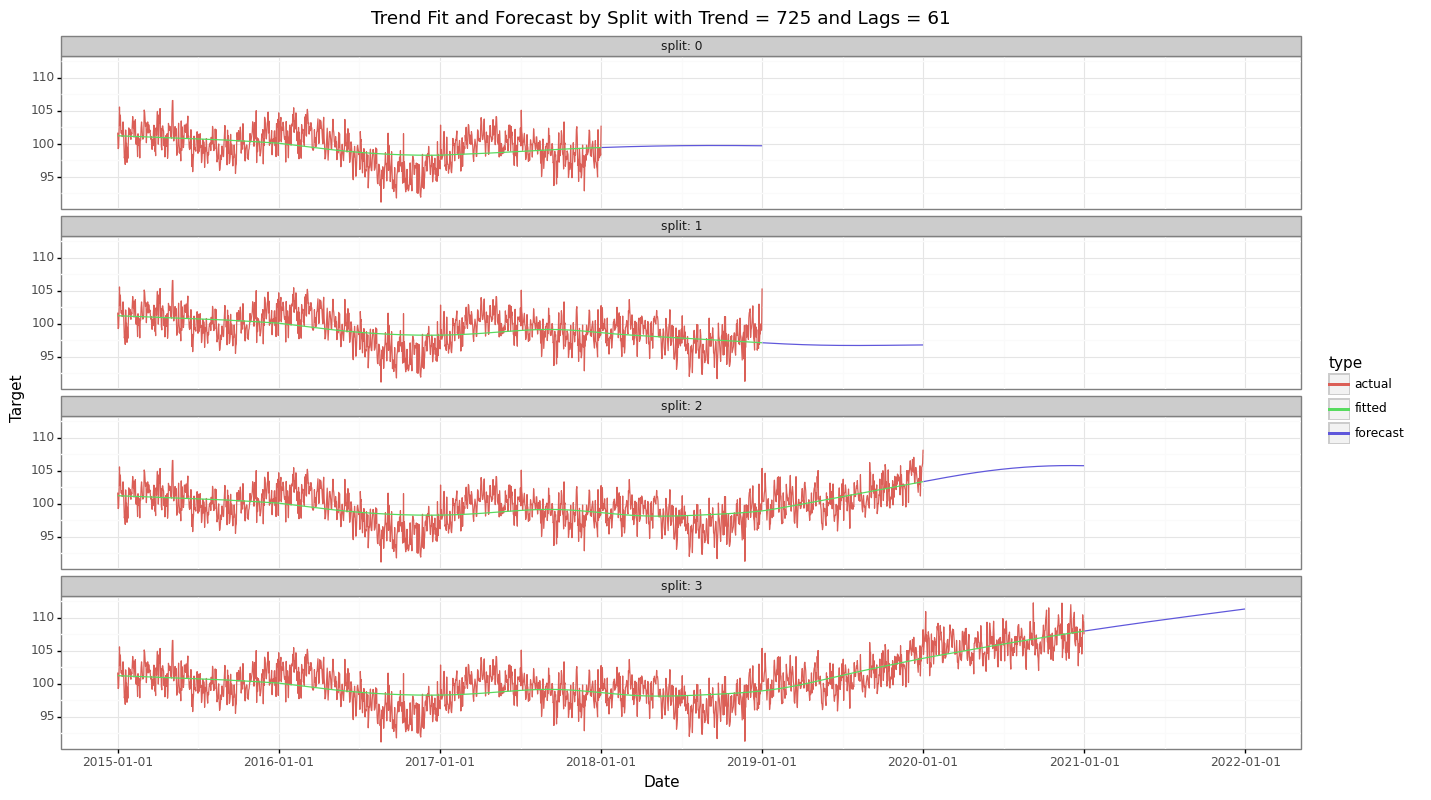

<ggplot: (121110632635)>

In [43]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_trend_results, aes("dt", "trend", color="type")) +
    geom_line() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "Target", title = "Trend Fit and Forecast by Split with Trend = " + str(n_trend) + " and Lags = " + str(n_lags)) +
    theme_bw()
)


## De-Trend the Time Series

De-trend the time series so that we can train the tree-based model on the data without needing to worry if the forecast horizon will extrapolate outside the range of values seen in the training data.

In [44]:
df_detrend_results = pd.DataFrame()
for split in np.arange(0, n_splits):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    x_train = np.ravel(df.loc[train_index, ["dt"]])
    y_train = np.ravel(df.loc[train_index, ["y"]])
    y_trend = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    df_detrend = pd.DataFrame({"dt": x_train, "detrend": y_train - y_trend, "split": split})
    df_detrend_results = pd.concat([df_detrend_results, df_detrend])
    seconds = time.time() - t1
    print("Detrending for split ", str(split), ":", sec_to_hms(seconds))

Detrending for split  0 : 0:00:0.01
Detrending for split  1 : 0:00:0.01
Detrending for split  2 : 0:00:0.01
Detrending for split  3 : 0:00:0.01


## Plot the Detrended Time Series

Note that cyclic patterns still exist.

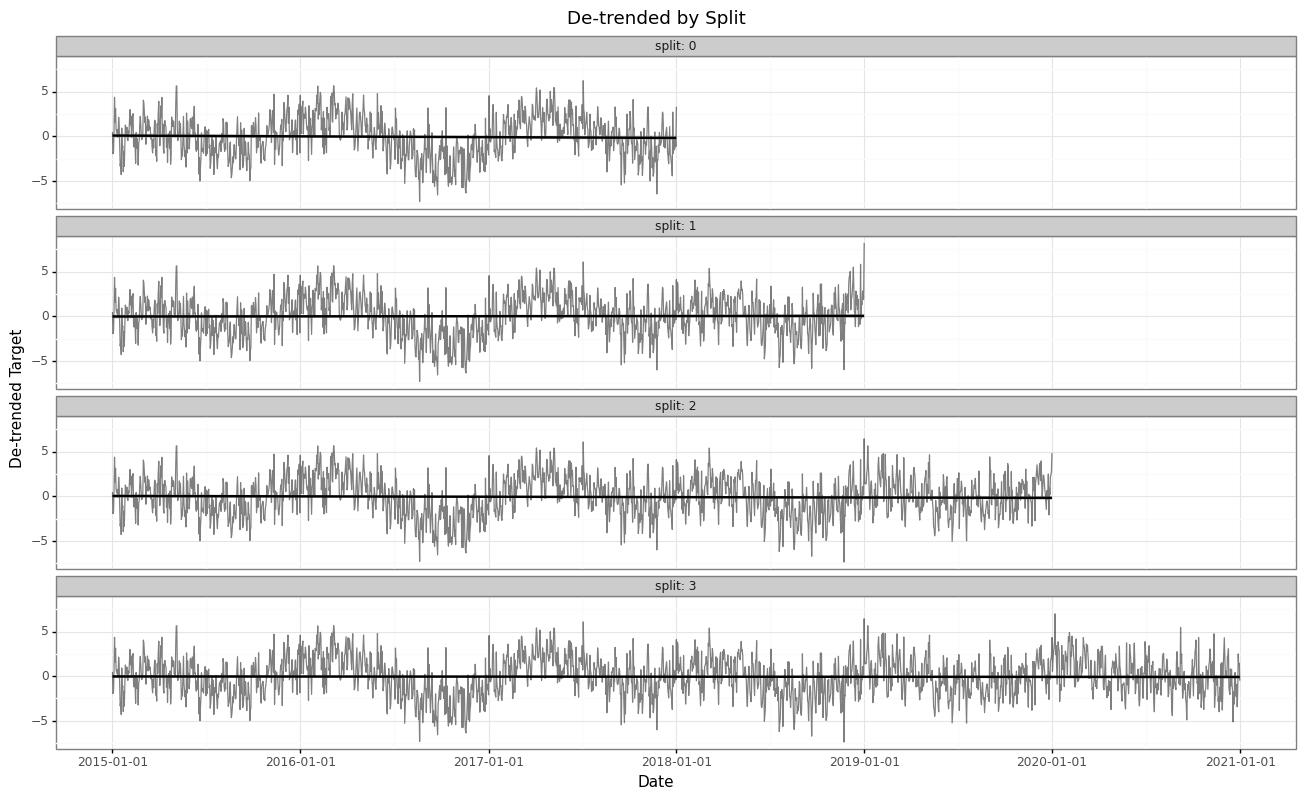

<ggplot: (121110417333)>

In [45]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_detrend_results, aes("dt", "detrend")) +
    geom_line(alpha = 0.5) +
    geom_smooth() + 
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "De-trended Target", title = "De-trended by Split") +
    theme_bw()
)

## Fit a Tree-Based Model

Train a tree-based model on the de-trended time series. 

In [49]:
df_tree_pred = pd.DataFrame()
for split in np.arange(0, n_splits):
    t1 = time.time()
    tree_mod = HistGradientBoostingRegressor(max_iter=300, max_depth=30, learning_rate=0.1, l2_regularization=0.1) # Model Spec
    train_index, test_index = all_splits[split] # Train/Test Splits for X and Y
    x_train = df.loc[train_index, x_vars]
    x_test = df.loc[test_index, x_vars]
    y_train = np.ravel(df_detrend_results.query("split==@split")["detrend"])
    df_tree_train_split = df.loc[train_index,["dt"]]
    df_tree_train_split["trend"] = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    df_tree_train_split["y"] = y_train
    df_tree_train_split["split"] = split
    df_tree_train_split["type"] = "actual"
    tree_mod.fit(X = x_train, y = y_train) # Fit Model
    df_tree_pred_split = df.loc[test_index,["dt"]] # Make Predictions
    df_tree_pred_split["trend"] = np.ravel(df_trend_results.query("split==@split and type=='forecast'")["trend"])
    df_tree_pred_split["y"] = tree_mod.predict(X=x_test)
    df_tree_pred_split["split"] = split
    df_tree_pred_split["type"] = "forecast"
    df_tree_pred = pd.concat([df_tree_pred, df_tree_train_split, df_tree_pred_split]) # Collect Results
    seconds = time.time() - t1
    print("Training time for split:", split.astype("str"), "=", sec_to_hms(seconds))

Training time for split: 0 = 0:00:1.38
Training time for split: 1 = 0:00:1.26
Training time for split: 2 = 0:00:1.29
Training time for split: 3 = 0:00:1.29


Plot the tree-model forecasts/predictions.

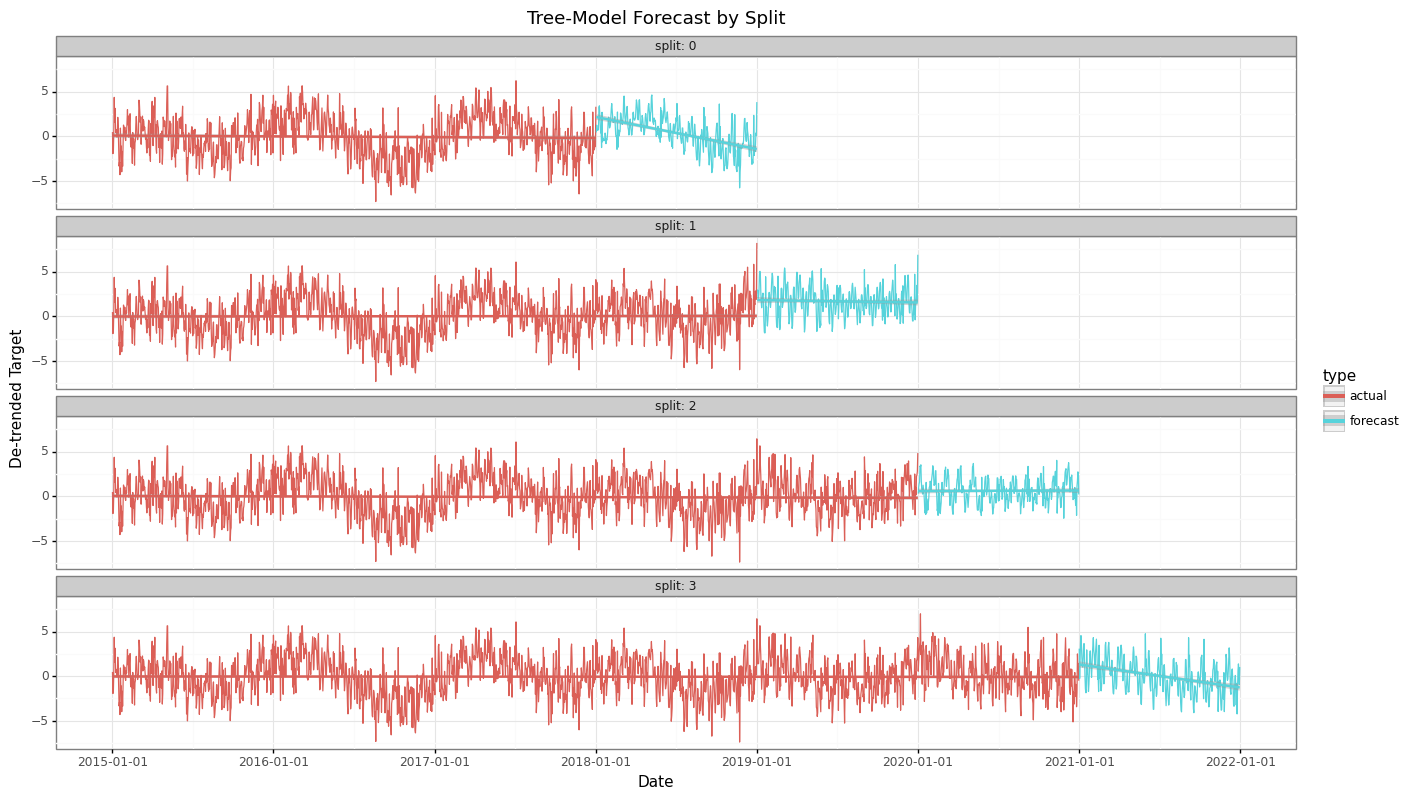

<ggplot: (121112541245)>

In [50]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_tree_pred, aes("dt", "y", color="type")) +
    geom_line() +
    geom_smooth() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "De-trended Target", title = "Tree-Model Forecast by Split") +
    theme_bw()
)

## Combine Forecasts

Combine the trend forecast and the tree-model forecast for each split.

In [51]:
df_forecast_all = df_tree_pred.copy()
df_forecast_all["combined"] = df_forecast_all["trend"] + df_forecast_all["y"]
df_forecast_all

,dt,trend,y,split,type,combined
0,2015-01-01,101.211649,0.476782,0,actual,101.688431
1,2015-01-02,101.209068,-1.942865,0,actual,99.266203
2,2015-01-03,101.206488,-1.761476,0,actual,99.445012
3,2015-01-04,101.203910,0.539581,0,actual,101.743491
4,2015-01-05,101.201334,4.369426,0,actual,105.570760
...,...,...,...,...,...,...
2552,2021-12-27,111.277232,0.609457,3,forecast,111.886690
2553,2021-12-28,111.285959,1.379768,3,forecast,112.665727
2554,2021-12-29,111.294685,0.762256,3,forecast,112.056941
2555,2021-12-30,111.303413,-0.908822,3,forecast,110.394591


Plot the forecasts

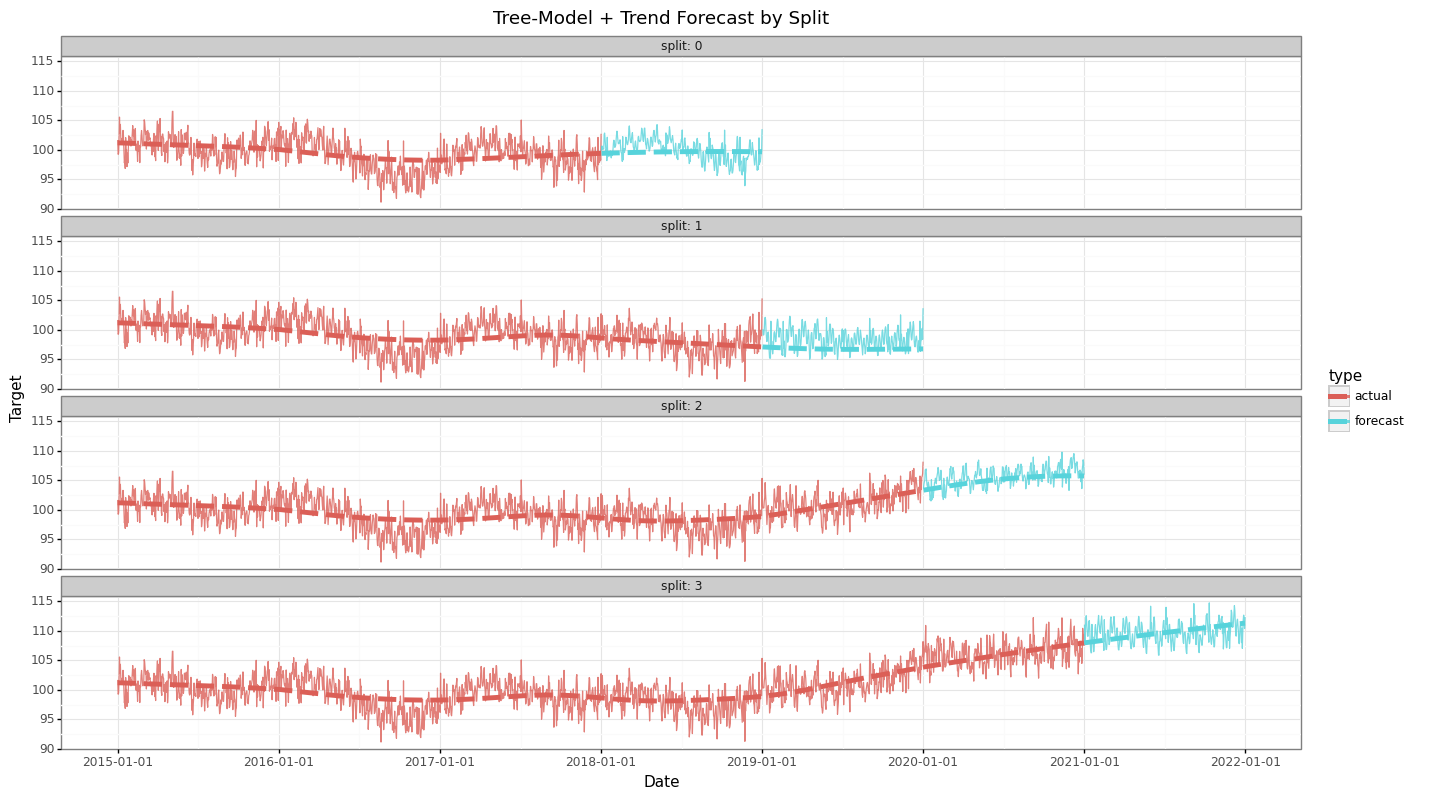

<ggplot: (121111537911)>

In [57]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_forecast_all, aes("dt", "combined", color="type")) +
    geom_line(alpha = 0.8) +
    geom_line(aes(y = "trend"), linetype="dashed", size=2) +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "Target", title = "Tree-Model + Trend Forecast by Split") +
    theme_bw()
)

## ARIMA Model

For benchmarking, fit a ARIMAX model using auto_arima() from pmdarima.

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

SARIMAX = Seasonal (S) Auto-Regressive (AR) Integrated (I) Moving-Average (MA) with eXogenous (X) regressors

In [58]:
df_arima_results = pd.DataFrame()
for split in np.arange(0, len(all_splits)):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    endog_train = df.loc[train_index, ["y"]] # Endog (Target) for Training
    exog_train = df.loc[train_index, x_vars] # Exog (Features) for Training
    ar_model = pm.auto_arima(y=endog_train, exogenous=exog_train, seasonal=True, D=1, m=7, stepwise=True, maxiter=10) # Auto-ARIMA procedure
    ar_pred = ar_model.predict(n_periods=len(test_index), X=df.loc[test_index, x_vars]) # Make forecasts
    df_arima_fore = pd.DataFrame({"dt": np.ravel(df.loc[test_index, ["dt"]]), "y":ar_pred, "split":split, "type":"forecast"}) # Save forecasts
    df_arima_past = pd.DataFrame({"dt": np.ravel(df.loc[train_index, ["dt"]]), "y":np.ravel(endog_train.values), "split":split, "type":"actual"}) # Save actuals (past)
    df_arima_results = pd.concat([df_arima_results, df_arima_past, df_arima_fore], axis=0) # Collect results
    seconds = time.time() - t1
    print("Split " + split.astype("str") + " training time = " + sec_to_hms(seconds))

Split 0 training time = 0:02:9.11
Split 1 training time = 0:01:16.58
Split 2 training time = 0:03:14.99
Split 3 training time = 0:03:28.88


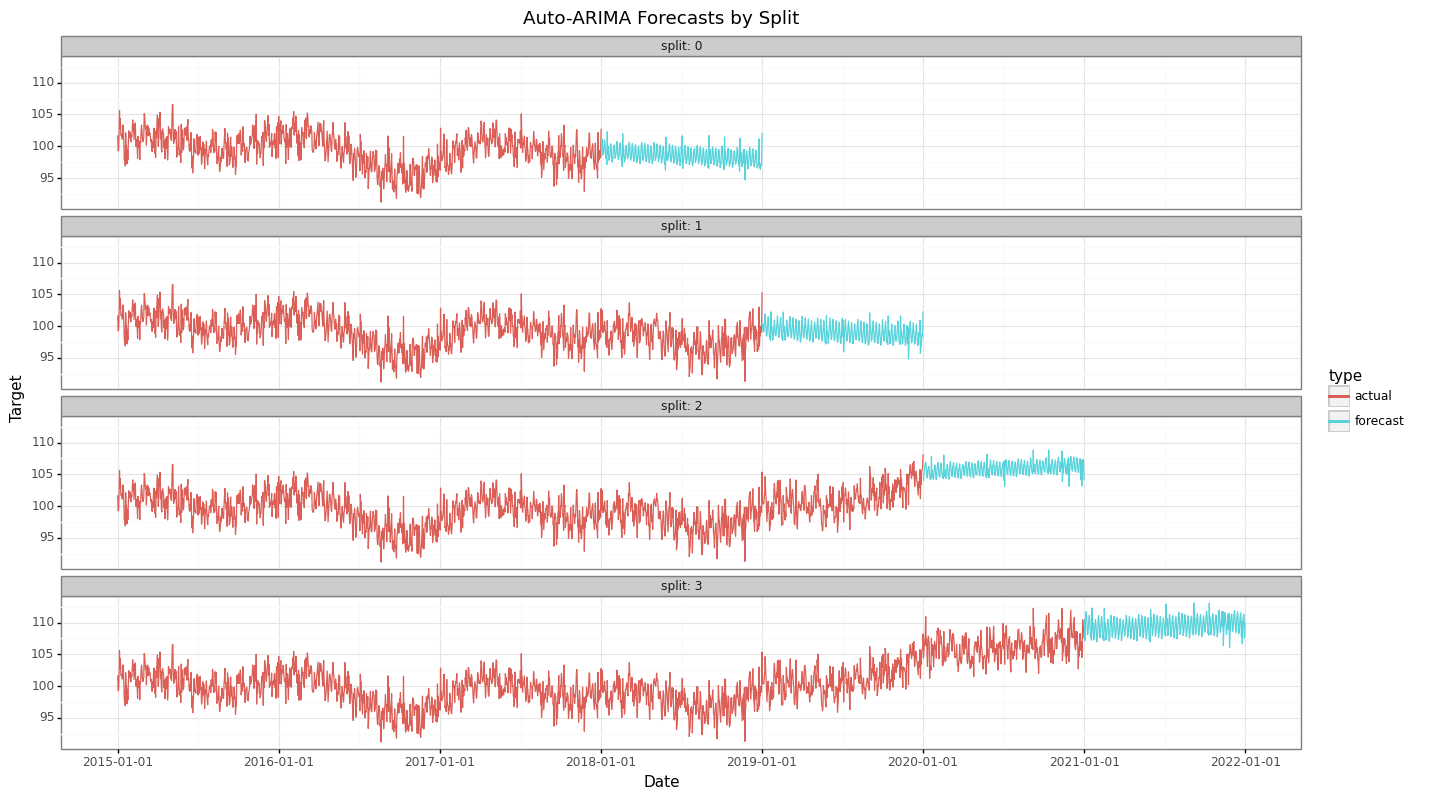

<ggplot: (121108680361)>

In [59]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_arima_results, aes("dt", "y", color="type")) +
    geom_line() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "Target", title = "Auto-ARIMA Forecasts by Split") +
    theme_bw()
)

## Compare Forecast Error 

Use Lev's custom error function to calculate the forecast error.

See this [repo](https://github.com/lselector/statistics/blob/master/nb_Time_Series_Forecast_Error.ipynb) for more details.

In [60]:
from sklearn.metrics import mean_squared_error
# Function from Lev's Repo
def fin_err(actual, 
            predicted, 
            norm=None,
            err_type='mae',   # mae or rmse
            noise_level_relative=1e-2,
            noise_level_absolute=1e-2,
            max_error=1e2):
    """
    # calculate relative difference 
    # between two arrays (or lists): actual & predicted
    # fin_err() is similar to normalized_mean_absolute_error
    # but optimized for financial data.
    # It takes into account not only amplitude of oscillations,
    # but also the "level" of values.
    # It also limits maximum error in cases when 
    # actual signal doesn't change much
    # optional parameters:
    #   norm (when provided) used as denominator
    #   noise_level_relative (default 0.01)
    #   noise_level_absolute (default 0.01)
    #   max_error (default 100.0)
    """
    Na, Np = len(actual), len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    np_act = np.array(actual, dtype = np.float64)
    np_pre = np.array(predicted, dtype = np.float64)
    if err_type == 'mae': # Mean Absolute Error
        myerr = np.abs(np_act - np_pre).sum() / Na
    elif err_type == 'rmse': # Root Mean Square Error
        myerr = math.sqrt(mean_squared_error(np_act, np_pre)) 
    else:
        print("ERROR: err_type should be 'mae' or 'rmse', exiting ...")
        sys.exit(1)
    if norm and norm > 0: # normalize - and limit
        return min (max_error, myerr / norm )  
    v_max_act, v_min_act = np.max(np_act), np.min(np_act) # max min   
    v_max_pre, v_min_pre = np.max(np_pre), np.min(np_pre) # max min  
    v_amp_act   = v_max_act - v_min_act        # amplitude      
    v_amp_pre   = v_max_pre - v_min_pre        # amplitude      
    v_level_act = np.abs(np_act).sum() / Na    # level             
    v_scale_act = max(v_level_act, v_amp_act)  # level
    v_level_pre = np.abs(np_pre).sum() / Na    # scale             
    v_scale_pre = max(v_level_pre, v_amp_pre)  # scale
    if (v_scale_act <= noise_level_absolute and 
        v_scale_pre <= noise_level_absolute):
            return 0 # actual and predicted are both close to zero 
    denom_min = max(v_scale_act * noise_level_relative,
                    noise_level_absolute)
    if v_scale_act > denom_min :
        denom = v_scale_act
    else:
        denom = denom_min
    return min (max_error, (myerr / denom))

In [61]:
for split in np.arange(0, n_splits):
    train_index, test_index = all_splits[split]
    y_pred_tree = np.ravel(df_forecast_all.query("split==@split and type=='forecast'").loc[:,["combined"]])
    y_pred_arima = np.ravel(df_arima_results.query("split==@split and type=='forecast'").loc[:,["y"]])
    y_actual = np.ravel(df.loc[test_index, ["y"]])
    # Calculate Error Stats
    tree_error = fin_err(actual=y_actual, predicted=y_pred_tree, err_type="rmse")
    arima_error = fin_err(actual=y_actual, predicted=y_pred_arima, err_type="rmse")
    # Print Error Stats
    print("-"*40)
    print("Errors for Split " + str(split) + ":")
    print("Tree-Based Model " + f"= {np.round(100*tree_error, 2)}" + "%")
    print("Auto-ARIMA Model " + f"= {np.round(100*arima_error, 2)}" + "%")

----------------------------------------
Errors for Split 0:
Tree-Based Model = 2.7%
Auto-ARIMA Model = 1.85%
----------------------------------------
Errors for Split 1:
Tree-Based Model = 3.21%
Auto-ARIMA Model = 3.09%
----------------------------------------
Errors for Split 2:
Tree-Based Model = 1.3%
Auto-ARIMA Model = 1.44%
----------------------------------------
Errors for Split 3:
Tree-Based Model = 1.81%
Auto-ARIMA Model = 1.81%


In [62]:
y_actual = np.ravel(df.tail(test_size*n_splits)["y"])
y_pred_tree = np.ravel(df_forecast_all.query("type=='forecast'").loc[:,["combined"]])
y_pred_arima = np.ravel(df_arima_results.query("type=='forecast'").loc[:,["y"]])
# Tree-Based Model
tree_error = fin_err(actual=y_actual, predicted=y_pred_tree, err_type='rmse')
# Auto-ARIMA Model
arima_error = fin_err(actual=y_actual, predicted=y_pred_arima, err_type="rmse")
# Print Error Metrics
print(f"Tree-Based Model = {np.round(100*tree_error, 2)}" + "%")
print(f"Auto-ARIMA Model = {np.round(100*arima_error, 2)}" + "%")

Tree-Based Model = 2.33%
Auto-ARIMA Model = 2.12%


# Forecasts zoomed in

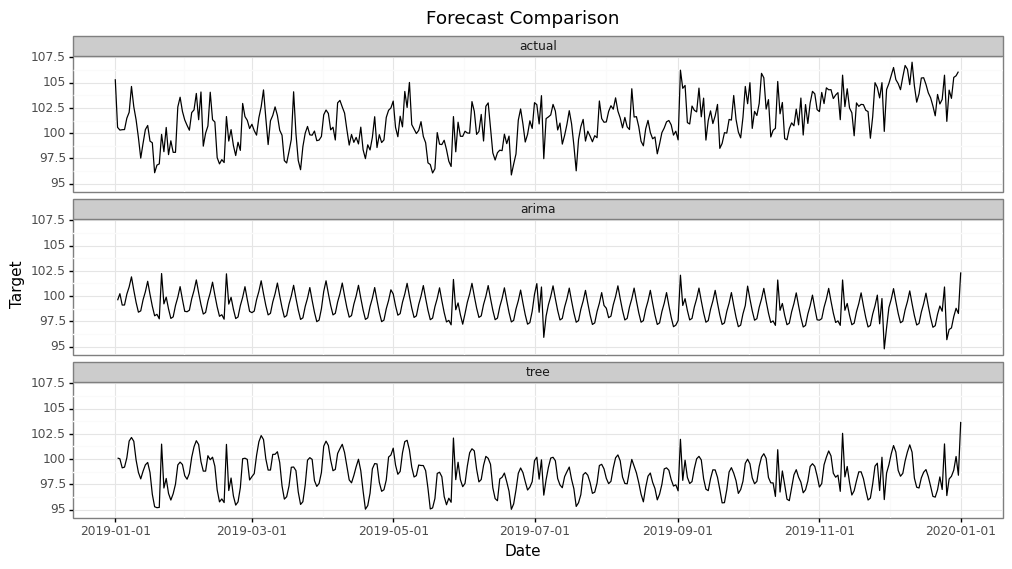

<ggplot: (121112152486)>

In [75]:
df_plot = pd.concat([
    df.query("dt>='2019-01-01' and dt<='2019-12-31'").loc[:,["dt","y"]].assign(type="actual"),
    df_forecast_all.query("split==1 & type=='forecast'").loc[:,["dt","combined"]].rename(columns={"combined":"y"}).assign(type="tree"),
    df_arima_results.query("split==1 & type=='forecast'").loc[:,["dt","y"]].assign(type="arima")
])
#df_plot["yr"] = df_plot["dt"].dt.year
plotnine.options.figure_size = (12,6)
(
    ggplot(df_plot, aes(x="dt", y="y")) +
    facet_wrap("~type", ncol=1) +
    geom_line() +
    labs(x = "Date", y = "Target", title = "Forecast Comparison") +
    theme_bw()
)